In [1]:
import numpy as np
import torch
import matplotlib.pylab as pl
import ot
import ot.plot
import pylab
import math

In [6]:
import sys
sys.path.append('../../code/')
from generate_data import make_data

In [7]:
def plot2D_samples_mat2(xs, xt, G, thr=1e-8, **kwargs):

    if ('color' not in kwargs) and ('c' not in kwargs):
        kwargs['color'] = 'k'
    mx = G.max()
    if 'alpha' in kwargs:
        scale = kwargs['alpha']
        del kwargs['alpha']
    else:
        scale = 1
    for i in range(xs.shape[0]):
        for j in range(xt.shape[0]):
            if G[i, j] / mx > thr:
                pl.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]],
                        alpha=G[i, j]/ mx, **kwargs)

In [8]:
def sinkhorn(a,b,C,lam=50,eps=1,numiter=500,pen=None,lam2=None,thr=1e-5):
    u_old=a
    v_old=b
    u=a
    G=torch.exp(-C/eps) #Gibbs Kernel
    uy=G.T@u
    ux=None
    
    if lam2 is None:
        lam2=lam
        
    for i in range(numiter):
        if pen is None:
            prox=b
        elif pen=="kl":
            prox=prox_KL(G.T@u,b,lam2,eps)                     
        v=prox/(G.T@u)
        
        if pen is None:
            prox=a
        elif pen=="kl":
            prox=prox_KL(G@v,a,lam,eps)
        u=prox/(G@v)
    
        if (torch.norm(u_old-u)+torch.norm(v-v_old))<thr: #If convergences early stop
                P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
                return P
        else:
            u_old=u
            v_old=v
    P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
    return P


      
def prox_KL(Gu,b,lam,eps):
    gam1=lam/(eps+lam)
    gam2=eps/(eps+lam)
    return (Gu**gam2)*(b**gam1)

In [9]:
bl="#4A90E2"
o='#F5A623'
v="#7ED321"

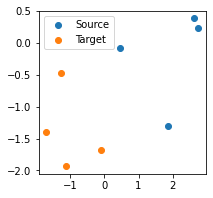

In [10]:
ns=4
nt=4
dim=2


torch.manual_seed(0)
np.random.seed(1)
X,_=make_data("gaussians",ns,dim)
_,Y=make_data("gaussians",nt,dim)

pl.figure(figsize=(3,3))
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source')
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target')
pl.legend(loc=2)

In [11]:
a, b = torch.ones((ns,)) / ns, torch.ones((nt,)) / nt 
C=ot.dist(X,Y)
C/=C.max()

P_KL= sinkhorn(a,b,C,lam=5e-2,eps=1e-2,numiter=500,pen="kl")*8
torch.sum(P_KL)

tensor(1.2063)

/tmp/ipykernel_7817/3299181473.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


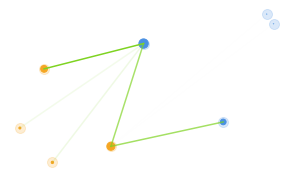

In [13]:
s=1e2
pl.figure(figsize=(5,3))
grid = pl.GridSpec(1, 1, wspace=0.4, hspace=0.5)

pl.subplot(grid[0,0])   
plot2D_samples_mat2(X,Y,P_KL.numpy(), c=v)
pl.scatter(X[:, 0], X[:, 1],c=bl, label='Source samples',s=torch.sum(P_KL,axis=1)*s)
pl.scatter(Y[:, 0], Y[:, 1], c=o, label='Target samples',s=torch.sum(P_KL,axis=0)*s)
pl.scatter(X[:, 0], X[:, 1],c=bl, label='Source samples',s=s,alpha=0.2)
pl.scatter(Y[:, 0], Y[:, 1], c=o, label='Target samples',s=s,alpha=0.2)
pl.axis("off")


pl.tight_layout()
pl.savefig("../../Figures/UOT/UOT_KL_Sinkhorn.pdf",bbox_inches='tight')

In [11]:
# Lasso

In [12]:
final_gamma = 1e-3
t, t_list, g_list = ot.regpath.regularization_path(a.numpy(), b.numpy(), C.numpy(), reg=final_gamma,
                                                   semi_relaxed=False)

In [13]:
g_list2=np.zeros(len(g_list))
t_list2=np.zeros((ns,nt,len(g_list)))
for i in range(len(g_list)):
    t_list2[:,:,i]=t_list[i].reshape((ns,nt))
    g_list2[i]=np.log(1/g_list[i])
g_list3=g_list2-g_list2.min()+1

In [14]:
for i in range(1,len(g_list)-1):
    for j in range(ns):
        for k in range(nt):
            if t_list2[j,k,i]==0 and t_list2[j,k,i+1]==0:
                t_list2[j,k,i] = np.nan

In [15]:
g_list4=[g_list3[0],g_list3[1],g_list3[2],g_list3[3],g_list3[10],g_list3[11]]
g_list5=[g_list2[0],g_list2[1],g_list2[2],g_list2[3],g_list2[10],g_list2[11]]
for i in range(len(g_list5)):
    g_list5[i]="{:.0e}".format(np.exp(g_list5[i]))

In [17]:
g_list4,g_list5

([1.0,
  1.1658395471309198,
  1.471465937259254,
  2.181257429980468,
  3.405390981464884,
  9.249987622724463],
 ['3e-01', '3e-01', '4e-01', '9e-01', '3e+00', '1e+03'])

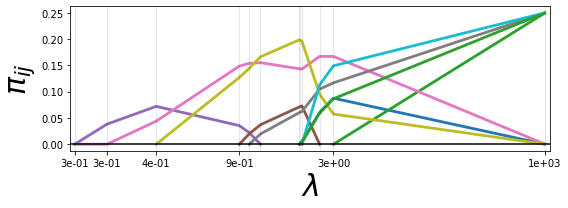

In [18]:
s=1e2
fig=pl.figure(figsize=(8,3))
ax = pl.axes() 
for i in range(ns):
    for j in range(nt):
        pl.plot(g_list3,t_list2[i,j,:],linewidth=2.8)
for i in range(len(g_list)):
    pl.axvline(x=g_list3[i], c="k", linewidth=1,alpha=.1)
    
pl.axhline(y=0, color='k', linestyle='-')
pl.xscale('log')
ax.minorticks_off()
ax.set_xticks(g_list4)
ax.set_xticklabels(g_list5)

pl.xlim(.98,9.5)
pl.xlabel("$\lambda$",size=30)
pl.ylabel("$\pi_{ij}$",size=30)

pl.tight_layout()
#pl.savefig("./Figures/UOT_l2_Lasso.pdf",bbox_inches='tight')